# Deep Learning for Computer Vision:  HW 2


#### MLP for XOR data

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [ ]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,-0.024796,0.904501,1.0
1,0.800496,0.051200,1.0
2,-0.108083,0.131192,0.0
3,0.119454,-0.317154,0.0
4,-0.042294,-0.154474,0.0


Let's message this data into a numpy format.

In [ ]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]
print(X.shape)
# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)
#print(X)

(5000, 2)


Let's make a sloppy plotting function for our binary data.

In [ ]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

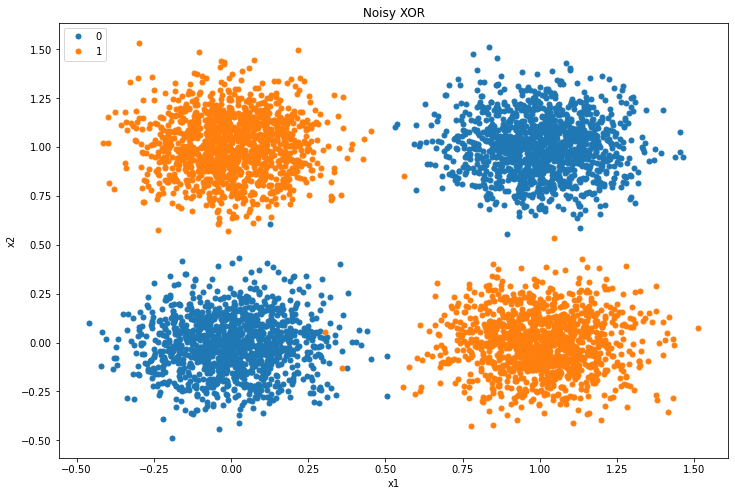

In [ ]:
plot_data(X, y)


Now let's create functions for forward and backward prop through the layers and we are off...

$(a)$ 

In [ ]:
"""
self defined activation functions
"""  


'\nself defined activation functions\n'

In [ ]:
class MLP: 
  def initialize(self, lr, batch_size, num_input, num_hidden):
    np.random.seed(0)
    self.lr = lr
    self.batch_size = batch_size
    # hidden layer weight
    self.W = np.random.uniform(size=(num_hidden, num_input))
    # output layer weight
    self.w = np.random.uniform(size=(1, num_hidden))
    self.c = np.random.uniform(size=(1, num_hidden))
    self.b = np.random.uniform(size=(1, 1)) 

  def softplus(self, x):
    x[np.where(x > 10)] = x[np.where(x > 10)]
    x[np.where(x <= 10)] = np.log(1 + np.exp(x[np.where(x <= 10)]))
    return x
  
  def relu(self, x):
    x[x <= 0] = 0
    return x

  def sigmoid(self, x):
    y = np.power((1 + np.exp(-x)), -1)
    return y
  
  def forward_hidden_layer(self, X):
    # implement W^T x + c
    c = np.tile(self.c, (self.batch_size, 1))
    hidden_out = X.dot(self.W.T) + c
    h = self.relu(hidden_out)
    
    return h, hidden_out
    
  def forward_out(self, h):
    #implement w^T x + b, where x is output of the hidden layer
    z = h.dot(self.w.T) + self.b
    return z
  
  def forward_loss(self, z, y):
    #obtain loss using softplus
    losses = self.softplus((1 - 2 * y) * z)
    loss = np.mean(losses)
    return loss
  

  def forward(self, X, y):
    # hidden layer
    h, hidden_out = self.forward_hidden_layer(X)
    # output layer
    z = self.forward_out(h)
    loss = self.forward_loss(z, y)
    return h, hidden_out, z, loss

  def get_mean(self, x):
    sum = 0
    for i in range(x.shape[0]):
      sum+=x[i]
    return sum / x.shape[0]

  def backward_loss(self, y, z):
    #L to z: dL/dz = sigmoid(1-2y) * (1-2y)
    dL_dz = self.sigmoid((1 - 2 * y) * z) * (1 - 2 * y)
    return dL_dz


  def backward_out(self, dL_dz, h):
    """
    Lz to h: 
    u3 = w*h,
    z = u3 + b
    dL/du3 = dL/dz * dz/d(u3)
    dL/dh = dL/dz * dz/d(u3) * d(u3)/dh 
    dL/dh = dL/dz * w
    dL/dw = dL/dz * h
    dL/db = dL/dz * dz/db
    """
    dL_dh = dL_dz.dot(self.w)
    dL_dw = dL_dz.T.dot(h)
    dL_db = self.get_mean(dL_dz)
    return dL_dh, dL_dw, dL_db
  
  def backward_hidden_layer(self, dL_dh, hidden_out, X):
    """
    h to input:
    h to u2: we used relu for hidden layer, h = max(0, u2)
    dh/du2 is a diagonal matrix similar to [[dh1/du1, 0], [0, dh2/du2]]
    dh_dr is partal derivative of hidden_out = W^T + c
    dL/dr = dL/dh * dh/dr
    dL/dw = dL/dh * dh/dw  = (dh/dr)^T * W
    dL/dc = dL/dh * dh/dc
    """
    dh_dr = np.zeros((hidden_out.shape[0], hidden_out.shape[1]))
    #reverse relu: if hidden_out = W^T + c >0, relu gives returns hidden_out
    dh_dr[hidden_out > 0] = 1

    dL_dr = dL_dh * dh_dr
    dL_dW = dL_dr.T.dot(X)
    dL_dc = self.get_mean(dL_dr)
    return dL_dW, dL_dc

  def backward(self, X, y, h, hidden_out, z):
    # output layer L to z
    dL_dz = self.backward_loss(y, z)
    # z to h
    dL_dh, dL_dw, dL_db = self.backward_out(dL_dz, h)
    # h to input
    dL_dW, dL_dc = self.backward_hidden_layer(dL_dh, hidden_out, X)
    # update variables
    self.W = self.W - self.lr * dL_dW
    self.c = self.c - self.lr * dL_dc
    self.w = self.w - self.lr * dL_dw
    self.b = self.b - self.lr * dL_db

  def get_error(self, X, y):
    error = 0
    y_hat = self.classify(X)
    for i in range(X.shape[0]):
      if y_hat[i] != y[i]:
        error += 1
    return error / X.shape[0]

  def classify(self, X):
    c = np.tile(self.c, (X.shape[0], 1))
    hidden_out = X.dot(self.W.T) + c
    h = self.relu(hidden_out)
    z = h.dot(self.w.T) + self.b
    pred = self.sigmoid(z)
    
    pred[np.where(pred > 0.5)] = 1
    pred[np.where(pred <= 0.5)] = 0
    return pred 



In [ ]:
def visualization(data, model):
  #background_color = [[0., 191., 255.], [255., 110., 180.], [202., 255., 112.],[156., 156., 156.]]
  fig, ax = plt.subplots(figsize=(12,8))
  prediction = model.classify(data)
  out = np.concatenate((data, prediction), axis = 1)
  #prediction = 1
  matrix1 = []
  #prediction = 0
  matrix2 = []
  for i in range(out.shape[0]):
    if out[i, -1] == 1: 
      matrix1.append(out[i, 0 : -1])
    else:
      matrix2.append(out[i, 0 : -1])
  matrix1 = np.squeeze(np.asarray(matrix1))
  matrix2 = np.squeeze(np.asarray(matrix2))
  ax.plot(matrix1[:, 0], matrix1[:,1], marker='o', linestyle='', ms=5, label='0')
  ax.plot(matrix2[:, 0], matrix2[:,1], marker='o', linestyle='', ms=5, label='1')

  ax.legend()
  ax.legend(loc=2)
  ax.set_xlabel('x1')
  ax.set_ylabel('x2')
  ax.set_title('Visualization')
  plt.show()

$(b)$ and $(c)$

accuracy of 49th iteration is :0.9986


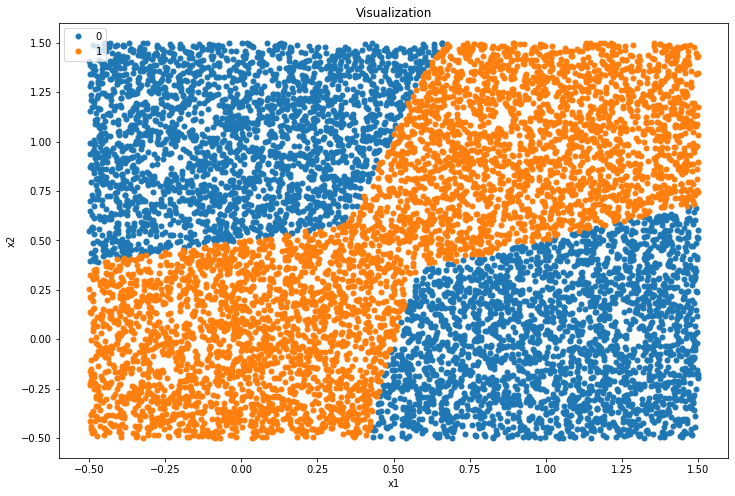

In [ ]:
# Train
model = None
model = MLP()
batch_size = 100
#lr, batch_size, num_input, num_hidden
model.initialize(0.01, batch_size, 2, 100)
combined_data = np.concatenate((X, y), axis = 1)
np.random.seed(0)

epoch = 50
prediction = []
empty_list = []

for i in range(epoch):
  combined_data = np.random.permutation(combined_data)
  #j: jth batch
  for j in range(X.shape[0] // 5 * 4  // batch_size):
      ## for 
      X_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, 0:2]
      y_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, [2]]
      h, hidden_out, z, l = model.forward(X_train, y_train) 
      model.backward(X_train, y_train, h, hidden_out, z)
  prediction.append(model.get_error(combined_data[:, 0:2], combined_data[:, -1]))
print("accuracy of " + str(i) + "th iteration is :" + str(1 - prediction[-1]))
#generate boundary
data = np.random.uniform(-0.5, 1.5, (10000, 2)) 
visualization(data, model)

In [ ]:
temp = np.concatenate((X, y), axis = 1)
print(X.size)
print(y.size)
print(temp.size)

10000
5000
15000


$(d)$ The more hidden units the more accurate the results become.

- using 3 hidden units

accuracy of 49th iteration is :0.7222


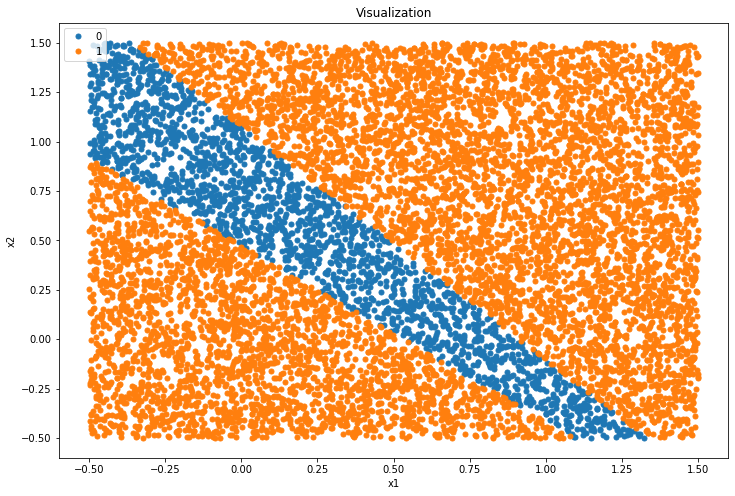

In [ ]:
# Train
model = None
model = MLP()
batch_size = 150
#lr, batch_size, num_input, num_hidden
model.initialize(0.01, batch_size, 2, 3)
combined_data = np.concatenate((X, y), axis = 1)
np.random.seed(0)

epoch = 50
prediction = []
empty_list = []

for i in range(epoch):
  combined_data = np.random.permutation(combined_data)
  #j: jth batch
  for j in range(X.shape[0] // 5 * 4  // batch_size):
      ## for 
      X_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, 0:2]
      y_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, [2]]
      h, hidden_out, z, l = model.forward(X_train, y_train) 
      model.backward(X_train, y_train, h, hidden_out, z)
  prediction.append(model.get_error(combined_data[:, 0:2], combined_data[:, -1]))
print("accuracy of " + str(i) + "th iteration is :" + str(1 - prediction[-1]))
#generate boundary
data = np.random.uniform(-0.5, 1.5, (10000, 2)) 
visualization(data, model)

$(d)$ The more hidden units the more accurate the results become.

- using 16 hidden units

accuracy of 49th iteration is :0.9952


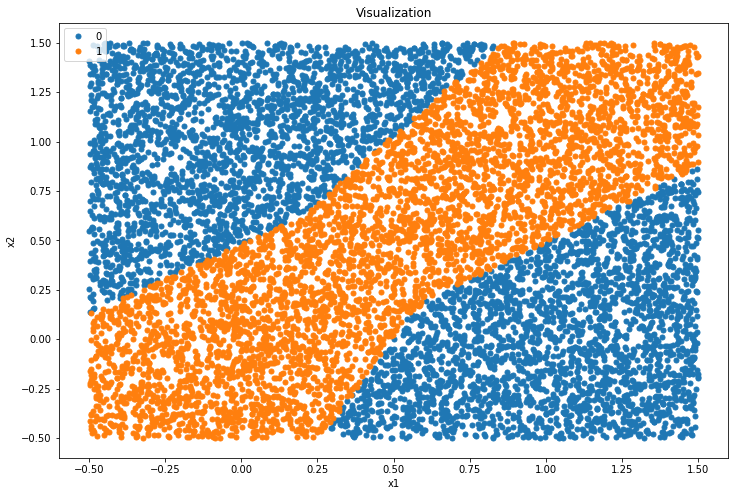

In [ ]:
# Train
model = None
model = MLP()
batch_size = 100
#lr, batch_size, num_input, num_hidden
model.initialize(0.01, batch_size, 2, 16)
combined_data = np.concatenate((X, y), axis = 1)
np.random.seed(0)

epoch = 50
prediction = []
empty_list = []

for i in range(epoch):
  combined_data = np.random.permutation(combined_data)
  #j: jth batch
  for j in range(X.shape[0] // 5 * 4  // batch_size):
      ## for 
      X_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, 0:2]
      y_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, [2]]
      h, hidden_out, z, l = model.forward(X_train, y_train) 
      model.backward(X_train, y_train, h, hidden_out, z)
  prediction.append(model.get_error(combined_data[:, 0:2], combined_data[:, -1]))
print("accuracy of " + str(i) + "th iteration is :" + str(1 - prediction[-1]))
#generate boundary
data = np.random.uniform(-0.5, 1.5, (10000, 2)) 
visualization(data, model)

$(d)$ The more hidden units the more accurate the results become.

- using 512 hidden units

accuracy of 49th iteration is :0.9988


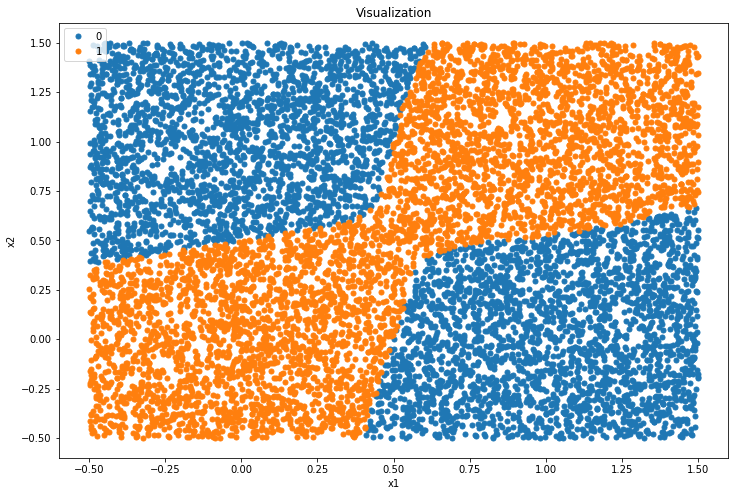

In [ ]:
# Train
model = None
model = MLP()
batch_size = 100
#lr, batch_size, num_input, num_hidden
model.initialize(0.01, batch_size, 2, 512)
combined_data = np.concatenate((X, y), axis = 1)
np.random.seed(0)

epoch = 50
prediction = []
empty_list = []

for i in range(epoch):
  combined_data = np.random.permutation(combined_data)
  #j: jth batch
  for j in range(X.shape[0] // 5 * 4  // batch_size):
      ## for 
      X_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, 0:2]
      y_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, [2]]
      h, hidden_out, z, l = model.forward(X_train, y_train) 
      model.backward(X_train, y_train, h, hidden_out, z)
  prediction.append(model.get_error(combined_data[:, 0:2], combined_data[:, -1]))
print("accuracy of " + str(i) + "th iteration is :" + str(1 - prediction[-1]))
#generate boundary
data = np.random.uniform(-0.5, 1.5, (10000, 2)) 
visualization(data, model)

$(e)$ use scaled softminus as loss function (softminus : log($e^r$ - 1))

In [ ]:
class MLP: 
  def initialize(self, lr, batch_size, num_input, num_hidden):
    np.random.seed(0)
    self.lr = lr
    self.batch_size = batch_size
    # hidden layer weight
    self.W = np.random.uniform(size=(num_hidden, num_input))
    # output layer weight
    self.w = np.random.uniform(size=(1, num_hidden))
    self.c = np.random.uniform(size=(1, num_hidden))
    self.b = np.random.uniform(size=(1, 1)) 
  
  def relu(self, x):
    x[x <= 0] = 0
    return x

  def softminus(self, x):
    x[np.where(x > 10)] = x[np.where(x > 10)]
    x[np.where(x <= 10)] = np.log(np.exp(x[np.where(x <= 10)])-1)
    return x

  def sigmoid(self, x):
    y = np.power((1 + np.exp(-x)), -1)
    return y
  
  def forward_hidden_layer(self, X):
    # implement W^T x + c
    c = np.tile(self.c, (self.batch_size, 1))
    hidden_out = X.dot(self.W.T) + c
    h = self.relu(hidden_out)
    
    return h, hidden_out
    
  def forward_out(self, h):
    #implement w^T x + b, where x is output of the hidden layer
    z = h.dot(self.w.T) + self.b
    return z
  
  def forward_loss(self, z, y):
    #obtain loss using softminus
    losses = self.softminus(2* (1 - 2 * y) * z)
    loss = np.mean(losses)
    return loss
  

  def forward(self, X, y):
    # hidden layer
    h, hidden_out = self.forward_hidden_layer(X)
    # output layer
    z = self.forward_out(h)
    loss = self.forward_loss(z, y)
    return h, hidden_out, z, loss

  def get_mean(self, x):
    sum = 0
    for i in range(x.shape[0]):
      sum+=x[i]
    return sum / x.shape[0]

  def backward_loss(self, y, z):
    #L to z: dL/dz = sigmoid(1-2y) * (1-2y)
    dL_dz = 2 * self.sigmoid(2 * (1 - 2 * y) * z) * (1 - 2 * y)
    return dL_dz


  def backward_out(self, dL_dz, h):
    """
    Lz to h: 
    u3 = w*h,
    z = u3 + b
    dL/du3 = dL/dz * dz/d(u3)
    dL/dh = dL/dz * dz/d(u3) * d(u3)/dh 
    dL/dh = dL/dz * w
    dL/dw = dL/dz * h
    dL/db = dL/dz * dz/db
    """
    dL_dh = dL_dz.dot(self.w)
    dL_dw = dL_dz.T.dot(h)
    dL_db = self.get_mean(dL_dz)
    return dL_dh, dL_dw, dL_db
  
  def backward_hidden_layer(self, dL_dh, hidden_out, X):
    """
    h to input:
    h to u2: we used relu for hidden layer, h = max(0, u2)
    dh/du2 is a diagonal matrix similar to [[dh1/du1, 0], [0, dh2/du2]]
    dh_dr is partal derivative of hidden_out = W^T + c
    dL/dr = dL/dh * dh/dr
    dL/dw = dL/dh * dh/dw  = (dh/dr)^T * W
    dL/dc = dL/dh * dh/dc
    """
    dh_dr = np.zeros((hidden_out.shape[0], hidden_out.shape[1]))
    #reverse relu: if hidden_out = W^T + c >0, relu gives returns hidden_out
    dh_dr[hidden_out > 0] = 1

    dL_dr = dL_dh * dh_dr
    dL_dW = dL_dr.T.dot(X)
    dL_dc = self.get_mean(dL_dr)
    return dL_dW, dL_dc

  def backward(self, X, y, h, hidden_out, z):
    # output layer L to z
    dL_dz = self.backward_loss(y, z)
    # z to h
    dL_dh, dL_dw, dL_db = self.backward_out(dL_dz, h)
    # h to input
    dL_dW, dL_dc = self.backward_hidden_layer(dL_dh, hidden_out, X)
    # update variables
    self.W = self.W - self.lr * dL_dW
    self.c = self.c - self.lr * dL_dc
    self.w = self.w - self.lr * dL_dw
    self.b = self.b - self.lr * dL_db

  def get_error(self, X, y):
    error = 0
    y_hat = self.classify(X)
    for i in range(X.shape[0]):
      if y_hat[i] != y[i]:
        error += 1
    return error / X.shape[0]

  def classify(self, X):
    c = np.tile(self.c, (X.shape[0], 1))
    hidden_out = X.dot(self.W.T) + c
    h = self.relu(hidden_out)
    z = h.dot(self.w.T) + self.b
    pred = self.sigmoid(z)
    
    pred[np.where(pred > 0.5)] = 1
    pred[np.where(pred <= 0.5)] = 0
    return pred 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


accuracy of 49th iteration is :0.7394000000000001


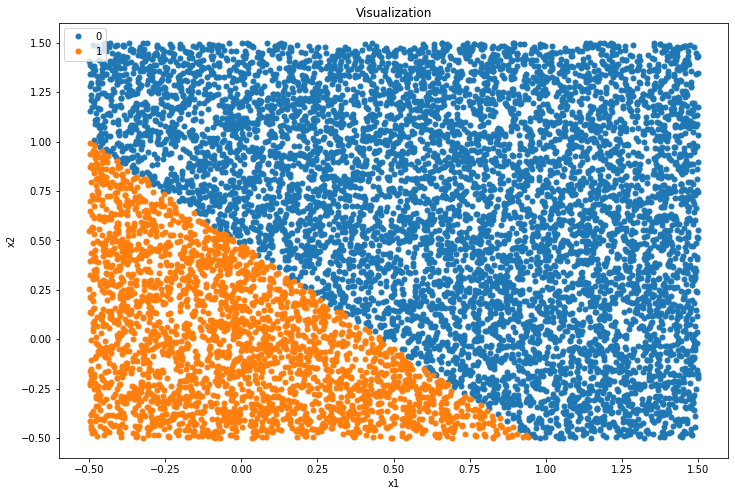

In [ ]:
# Train
model = None
model = MLP()
batch_size = 150
#lr, batch_size, num_input, num_hidden
model.initialize(0.01, batch_size, 2, 3)
combined_data = np.concatenate((X, y), axis = 1)
np.random.seed(0)

epoch = 50
prediction = []
empty_list = []

for i in range(epoch):
  combined_data = np.random.permutation(combined_data)
  #j: jth batch
  for j in range(X.shape[0] // 5 * 4  // batch_size):
      ## for 
      X_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, 0:2]
      y_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, [2]]
      h, hidden_out, z, l = model.forward(X_train, y_train) 
      model.backward(X_train, y_train, h, hidden_out, z)
  prediction.append(model.get_error(combined_data[:, 0:2], combined_data[:, -1]))
print("accuracy of " + str(i) + "th iteration is :" + str(1 - prediction[-1]))
#generate boundary
data = np.random.uniform(-0.5, 1.5, (10000, 2)) 
visualization(data, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


accuracy of 49th iteration is :0.9982


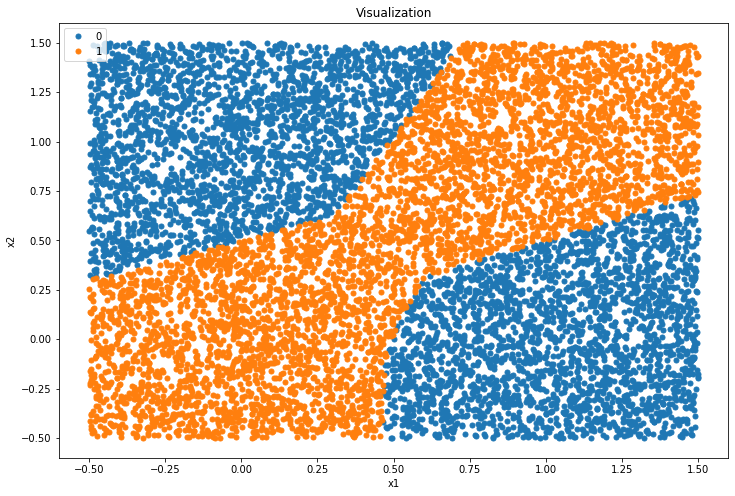

In [ ]:
# Train
model = None
model = MLP()
batch_size = 100
#lr, batch_size, num_input, num_hidden
model.initialize(0.01, batch_size, 2, 16)
combined_data = np.concatenate((X, y), axis = 1)
np.random.seed(0)

epoch = 50
prediction = []
empty_list = []

for i in range(epoch):
  combined_data = np.random.permutation(combined_data)
  #j: jth batch
  for j in range(X.shape[0] // 5 * 4  // batch_size):
      ## for 
      X_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, 0:2]
      y_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, [2]]
      h, hidden_out, z, l = model.forward(X_train, y_train) 
      model.backward(X_train, y_train, h, hidden_out, z)
  prediction.append(model.get_error(combined_data[:, 0:2], combined_data[:, -1]))
print("accuracy of " + str(i) + "th iteration is :" + str(1 - prediction[-1]))
#generate boundary
data = np.random.uniform(-0.5, 1.5, (10000, 2)) 
visualization(data, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


accuracy of 49th iteration is :0.9986


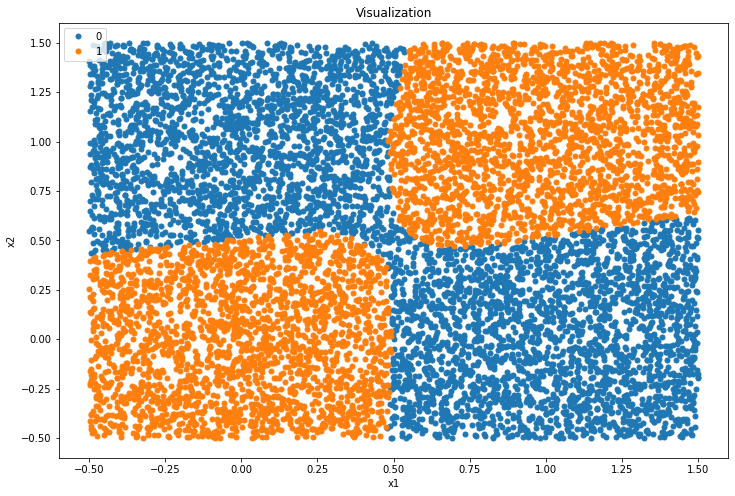

In [ ]:
# Train
model = None
model = MLP()
batch_size = 100
#lr, batch_size, num_input, num_hidden
model.initialize(0.01, batch_size, 2, 512)
combined_data = np.concatenate((X, y), axis = 1)
np.random.seed(0)

epoch = 50
prediction = []
empty_list = []

for i in range(epoch):
  combined_data = np.random.permutation(combined_data)
  #j: jth batch
  for j in range(X.shape[0] // 5 * 4  // batch_size):
      ## for 
      X_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, 0:2]
      y_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, [2]]
      h, hidden_out, z, l = model.forward(X_train, y_train) 
      model.backward(X_train, y_train, h, hidden_out, z)
  prediction.append(model.get_error(combined_data[:, 0:2], combined_data[:, -1]))
print("accuracy of " + str(i) + "th iteration is :" + str(1 - prediction[-1]))
#generate boundary
data = np.random.uniform(-0.5, 1.5, (10000, 2)) 
visualization(data, model)

$(f)$ Three input:
Need to change $XOR$ data: $x_1$, $x_2$, $x_3$

In [ ]:
data = pd.DataFrame(np.zeros((5000, 4)), columns=['x1', 'x2', 'x3', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    x3 = 1.0 * random.randint(0,1)
    """
    001
    010
    100
    111
    """
    y = 1.0 * (x1 + x2 + x3) % 2
    
    #print(sum)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    x3 = x3 * 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = x3
    data.iloc[i,3] = y
        
data.head()

,x1,x2,x3,y
0,0.091772,0.270337,-0.030677,1.0
1,0.014821,1.106327,0.191200,0.0
2,-0.005058,0.741146,-0.000000,1.0
3,1.092710,0.388607,0.057021,0.0
4,0.724831,-0.048719,-0.000000,1.0


In [ ]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
"""X = np.matrix(X.values)
y = np.matrix(y.values)"""
X_train= X.sample(frac=0.8, random_state=25)
X_test = X.drop(X_train.index)
y_train= y.sample(frac=0.8, random_state=25)
y_test = y.drop(y_train.index)

X_train = np.matrix(X_train.values)
y_train = np.matrix(y_train.values)
X_test = np.matrix(X_test.values)
y_test = np.matrix(y_test.values)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4000, 3) (1000, 3) (4000, 1) (1000, 1)


In [ ]:
class MLP: 
  def initialize(self, lr, batch_size, num_input, num_hidden):
    np.random.seed(0)
    self.lr = lr
    self.batch_size = batch_size
    # hidden layer weight
    self.W = np.random.uniform(size=(num_hidden, num_input))
    # output layer weight
    self.w = np.random.uniform(size=(1, num_hidden))
    self.c = np.random.uniform(size=(1, num_hidden))
    self.b = np.random.uniform(size=(1, 1)) 

  def softplus(self, x):
    x[np.where(x > 10)] = x[np.where(x > 10)]
    x[np.where(x <= 10)] = np.log(1 + np.exp(x[np.where(x <= 10)]))
    return x
  
  def relu(self, x):
    x[x <= 0] = 0
    return x

  def sigmoid(self, x):
    y = np.power((1 + np.exp(-x)), -1)
    return y
  
  def forward_hidden_layer(self, X):
    # implement W^T x + c
    c = np.tile(self.c, (self.batch_size, 1))
    hidden_out = X.dot(self.W.T) + c
    h = self.relu(hidden_out)
    
    return h, hidden_out
    
  def forward_out(self, h):
    #implement w^T x + b, where x is output of the hidden layer
    z = h.dot(self.w.T) + self.b
    return z
  
  def forward_loss(self, z, y):
    #obtain loss using softplus
    losses = self.softplus((1 - 2 * y) * z)
    loss = np.mean(losses)
    return loss
  

  def forward(self, X, y):
    # hidden layer
    h, hidden_out = self.forward_hidden_layer(X)
    # output layer
    z = self.forward_out(h)
    loss = self.forward_loss(z, y)
    return h, hidden_out, z, loss

  def get_mean(self, x):
    sum = 0
    for i in range(x.shape[0]):
      sum+=x[i]
    return sum / x.shape[0]

  def backward_loss(self, y, z):
    #L to z: dL/dz = sigmoid(1-2y) * (1-2y)
    dL_dz = self.sigmoid((1 - 2 * y) * z) * (1 - 2 * y)
    return dL_dz


  def backward_out(self, dL_dz, h):
    """
    Lz to h: 
    u3 = w*h,
    z = u3 + b
    dL/du3 = dL/dz * dz/d(u3)
    dL/dh = dL/dz * dz/d(u3) * d(u3)/dh 
    dL/dh = dL/dz * w
    dL/dw = dL/dz * h
    dL/db = dL/dz * dz/db
    """
    dL_dh = dL_dz.dot(self.w)
    dL_dw = dL_dz.T.dot(h)
    dL_db = self.get_mean(dL_dz)
    return dL_dh, dL_dw, dL_db
  
  def backward_hidden_layer(self, dL_dh, hidden_out, X):
    """
    h to input:
    h to u2: we used relu for hidden layer, h = max(0, u2)
    dh/du2 is a diagonal matrix similar to [[dh1/du1, 0], [0, dh2/du2]]
    dh_dr is partal derivative of hidden_out = W^T + c
    dL/dr = dL/dh * dh/dr
    dL/dw = dL/dh * dh/dw  = (dh/dr)^T * W
    dL/dc = dL/dh * dh/dc
    """
    dh_dr = np.zeros((hidden_out.shape[0], hidden_out.shape[1]))
    #reverse relu: if hidden_out = W^T + c >0, relu gives returns hidden_out
    dh_dr[hidden_out > 0] = 1

    dL_dr = dL_dh * dh_dr
    dL_dW = dL_dr.T.dot(X)
    dL_dc = self.get_mean(dL_dr)
    return dL_dW, dL_dc

  def backward(self, X, y, h, hidden_out, z):
    # output layer L to z
    dL_dz = self.backward_loss(y, z)
    # z to h
    dL_dh, dL_dw, dL_db = self.backward_out(dL_dz, h)
    # h to input
    dL_dW, dL_dc = self.backward_hidden_layer(dL_dh, hidden_out, X)
    # update variables
    self.W = self.W - self.lr * dL_dW
    self.c = self.c - self.lr * dL_dc
    self.w = self.w - self.lr * dL_dw
    self.b = self.b - self.lr * dL_db

  def get_error(self, X, y):
    error = 0
    y_hat = self.classify(X)
    for i in range(X.shape[0]):
      if y_hat[i] != y[i]:
        error += 1
    return error / X.shape[0]

  def classify(self, X):
    c = np.tile(self.c, (X.shape[0], 1))
    hidden_out = X.dot(self.W.T) + c
    h = self.relu(hidden_out)
    z = h.dot(self.w.T) + self.b
    pred = self.sigmoid(z)
    
    pred[np.where(pred > 0.5)] = 1
    pred[np.where(pred <= 0.5)] = 0
    return pred 





In [ ]:
# Train
model = None
model = MLP()
batch_size = 10
#lr, batch_size, num_input, num_hidden
model.initialize(0.01, batch_size, 3, 512)
combined_data = np.concatenate((X_train, y_train), axis = 1)
np.random.seed(0)
print("x train shape: " + str(X_train.shape))
print("y train shape: " + str(y_train.shape))

epoch = 50
prediction = []
empty_list = []
err = []
for i in range(epoch):
  combined_data = np.random.permutation(combined_data)
  #j: jth batch
  for j in range(X_train.shape[0] // batch_size):
      ## for 
      X_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, 0:-1]
      y_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, [-1]]
      h, hidden_out, z, l = model.forward(X_train, y_train) 
      model.backward(X_train, y_train, h, hidden_out, z)
  prediction.append(model.get_error(combined_data[:, 0:-1], combined_data[:, -1]))
  err.append(model.get_error(X_train, y_train))

print("accuracy of " + str(i) + "th iteration is :" + str(1 - err[-1]))

x train shape: (4000, 3)
y train shape: (4000, 1)
accuracy of 49th iteration is :0.6


In [ ]:
test_error = model.get_error(X_test, y_test)
print("test accuracy: " + str(1-test_error))

test accuracy: 0.48


$(g)$ My data from hw 1 looks really bad so I'm gonna import iris dataset from sklearn  

In [ ]:
#load iris data from sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
iris = load_iris()
X = iris.data[:, :2]
y = iris.target
y = y.reshape(150, 1)
print(y)
names = iris['target_names']
feature_names = iris['feature_names']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)
#print(X)
#print(y.shape)

NameError: ignored

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 2) (30, 2) (120, 1) (30, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


accuracy of 49th iteration is :0.65


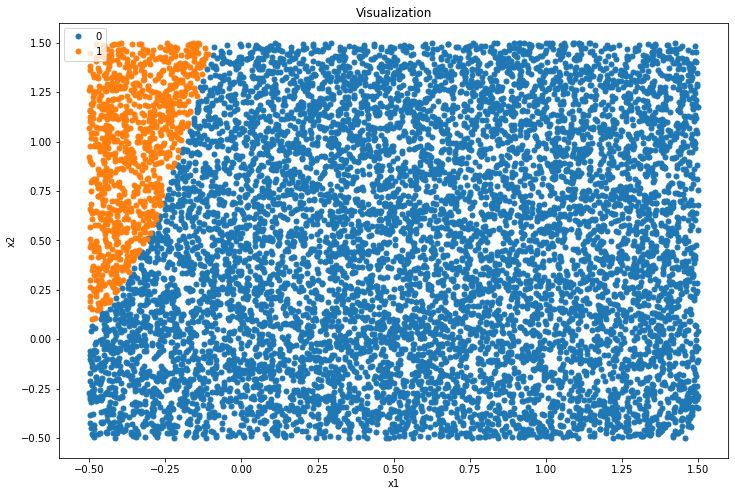

In [ ]:
# Train
model = None
model = MLP()
batch_size = 100
#lr, batch_size, num_input, num_hidden
model.initialize(0.01, batch_size, 2, 512)
combined_data = np.concatenate((X_train, y_train), axis = 1)
np.random.seed(0)

epoch = 50
prediction = []
empty_list = []
#dataset = np.random.permutation(dataset)
for i in range(epoch):
  #dataset = np.random.permutation(dataset)
  #combined_data = np.random.permutation(combined_data)
  #j: jth batch
  for j in range(X.shape[0] // 5 * 4  // batch_size):
      ## for 
      X_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, 0:2]
      y_train = combined_data[j * model.batch_size : (j + 1) * model.batch_size, [2]]
      h, hidden_out, z, l = model.forward(X_train, y_train) 
      model.backward(X_train, y_train, h, hidden_out, z)
  prediction.append(model.get_error(combined_data[:, 0:2], combined_data[:, -1]))
print("accuracy of " + str(i) + "th iteration is :" + str(1 - prediction[-1]))
#generate boundary
data = np.random.uniform(-0.5, 1.5, (10000, 2)) 
visualization(data, model)